In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('train-balanced-sarcasm.csv')

In [ ]:
data.shape

(1010826, 10)

In [ ]:
data['label'].value_counts()

0    505413
1    505413
Name: label, dtype: int64

In [ ]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [ ]:
data_pos_tr = data_pos.iloc[:450000]

data_pos_cv = data_pos_tr.iloc[400000:450000]
data_pos_tr = data_pos_tr.iloc[:400000]

data_pos_test = data_pos.iloc[450000:500000]

data_neg_tr = data_neg.iloc[:450000]

data_neg_cv = data_neg_tr.iloc[400000:450000]
data_neg_tr = data_neg_tr.iloc[:400000]

data_neg_test = data_neg.iloc[450000:500000]

In [ ]:
data_tr = pd.concat([data_pos_tr, data_neg_tr])
data_cv = pd.concat([data_pos_cv, data_neg_cv])
data_test = pd.concat([data_pos_test, data_neg_test])

In [ ]:
print('Shape of train data: {}'.format(data_tr.shape))
print('Shape of CV data: {}'.format(data_cv.shape))
print('Shape of test data: {}'.format(data_test.shape))

Shape of train data: (800000, 10)
Shape of CV data: (100000, 10)
Shape of test data: (100000, 10)


In [ ]:
data_tr.to_csv('train.csv', index=False)
data_cv.to_csv('cv.csv', index=False)
data_test.to_csv('test.csv', index=False)

In [ ]:
train = pd.read_csv('train.csv')
cv = pd.read_csv('cv.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,1,But they'll have all those reviews!,RoguishPoppet,ProductTesting,0,-1,-1,2016-11,2016-11-01 02:04:59,"The dumb thing is, they are risking their sell..."
1,1,wow it is totally unreasonable to assume that ...,pb2crazy,politics,2,-1,-1,2016-11,2016-11-01 02:42:11,Clinton campaign accuses FBI of 'blatant doubl...
2,1,Ho ho ho... But Melania said that there is no ...,pb2crazy,politics,8,-1,-1,2016-10,2016-10-18 16:20:53,Anyone else think that it was interesting the ...
3,1,I can't wait until @potus starts a twitter war...,kitduncan,politics,3,-1,-1,2016-11,2016-11-01 03:22:33,Here's what happens when Obama gives up his Tw...
4,1,gotta love the teachers who give exams on the ...,DEP61,CFBOffTopic,3,-1,-1,2016-11,2016-11-01 03:30:11,Monday night Drinking thread Brought to You by...


In [ ]:
train.shape

(800000, 10)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   label           800000 non-null  int64 
 1   comment         799972 non-null  object
 2   author          800000 non-null  object
 3   subreddit       800000 non-null  object
 4   score           800000 non-null  int64 
 5   ups             800000 non-null  int64 
 6   downs           800000 non-null  int64 
 7   date            800000 non-null  object
 8   created_utc     800000 non-null  object
 9   parent_comment  800000 non-null  object
dtypes: int64(4), object(6)
memory usage: 61.0+ MB


In [ ]:
train['label'].value_counts()

1    400000
0    400000
Name: label, dtype: int64

In [ ]:
!pip install 'fsspec>=0.3.3'

     |████████████████████████████████| 136 kB 21.7 MB/s 


In [ ]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import math
import pickle
import os

from gensim.models import KeyedVectors
from gensim.models.doc2vec import TaggedDocument
import gensim

from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score


import warnings
warnings.filterwarnings('ignore')

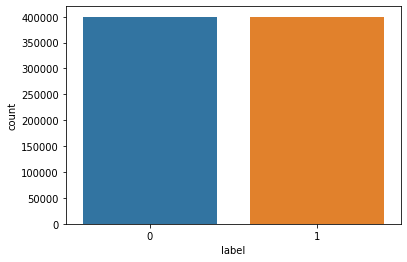

In [ ]:
sns.countplot(x='label', data=train)

In [ ]:
len(train['subreddit'].unique())

13432

In [ ]:
train[train['label'] == 1]['subreddit'].value_counts()[:20]

AskReddit          20088
politics           18080
worldnews          12470
pcmasterrace        9671
leagueoflegends     9333
news                8495
GlobalOffensive     7251
nba                 5831
nfl                 5815
todayilearned       5514
pics                4984
funny               4853
AdviceAnimals       4614
The_Donald          4458
videos              4350
TumblrInAction      3861
hockey              3797
gaming              3570
soccer              3361
CFB                 2730
Name: subreddit, dtype: int64

In [ ]:
len(train['author'].unique())

228956

In [ ]:
train[train['label'] == 1]['author'].value_counts()[:20]

Biffingston          219
pokemon_fetish       213
ShyBiDude89          187
NeonDisease          179
ivsciguy             161
mad-n-fla            150
mindlessrabble       129
sleaze_bag_alert     125
Chaoslab             123
JumpingJazzJam        97
DownvoteDaemon        94
EMINEM_4Evah          92
richardleosimones     84
InFearn0              82
TouchMeHerePls        79
kurisu7885            77
tau-lepton            76
Canada_girl           72
ozric101              72
AudibleNod            71
Name: author, dtype: int64

In [ ]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_font_size = 100, 
                random_state = 17, width=800, height=400)

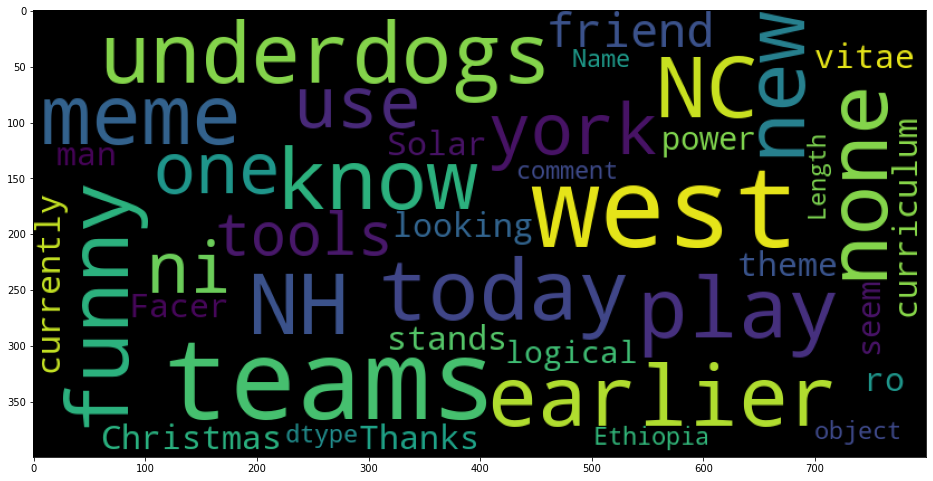

In [ ]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train.loc[train['label'] == 0, 'comment']))
plt.imshow(wordcloud)

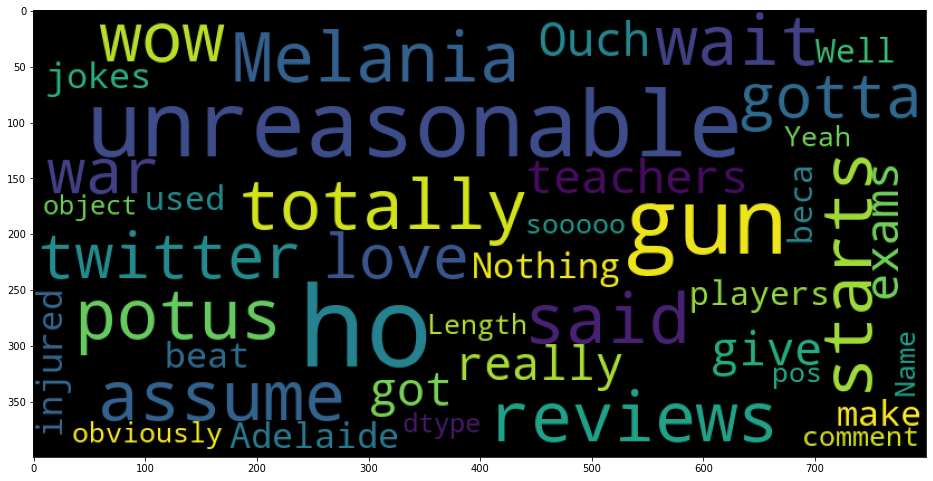

In [ ]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train.loc[train['label'] == 1, 'comment']))
plt.imshow(wordcloud)

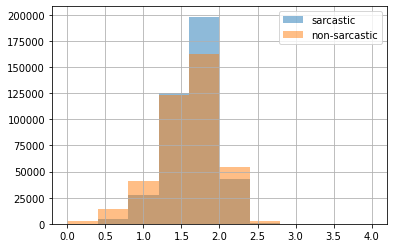

In [ ]:
train.loc[train['label'] == 1, 'comment'].str.len().apply(np.log10).hist(label='sarcastic', alpha=.5)
train.loc[train['label'] == 0, 'comment'].str.len().apply(np.log10).hist(label='non-sarcastic', alpha=.5)
plt.legend()

In [ ]:
#Data Cleaning
from emo_unicode import EMOTICONS

In [ ]:
def removeLinks(text):
    text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    return text

def removeHTMLTags(text):
    text = re.sub(r'<.*?>', '', text, flags=re.MULTILINE)
    return text

def convertToLowerCase(text):
    return text.lower()

def removeWordsWithNumbers(text):
    return re.sub(r'\S*\d\S*', '', text).strip()

def removePuctuations(text):
    return re.sub(r'[^A-Za-z0-9]+', ' ', text)

def removeWhiteSpaces(text):
    return text.strip()

def decontracted(phrase):
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

In [ ]:
def clean_data(text):
    
    text = str(text)
    text = removeLinks(text)
    text = removeHTMLTags(text)
    text = convertToLowerCase(text)
    text = removeWordsWithNumbers(text)
    text = removeWhiteSpaces(text)
    text = decontracted(text)
    text = removePuctuations(text)
    text = remove_emoji(text)
    text = remove_emoticons(text)
    text = text.strip()
    
    return text

In [ ]:
cleaned_train = train.dropna(how='any', axis=0)
cleaned_train['comment'] = cleaned_train['comment'].apply(clean_data)
cleaned_train['author'] = cleaned_train['author'].apply(removeWhiteSpaces)

cleaned_cv = cv.dropna(how='any', axis=0)
cleaned_cv['comment'] = cleaned_cv['comment'].apply(clean_data)
cleaned_cv['author'] = cleaned_cv['author'].apply(removeWhiteSpaces)

cleaned_test = test.dropna(how='any', axis=0)
cleaned_test['comment'] = cleaned_test['comment'].apply(clean_data)
cleaned_test['author'] = cleaned_test['author'].apply(removeWhiteSpaces)

In [ ]:
#testing
train['comment'].iloc[66]

'Because anecdotes mean anything and being gay/trans is evil'

In [ ]:
#testing
cleaned_train['comment'].iloc[66]

'because anecdotes mean anything and being gay trans is evil'

In [ ]:
cleaned_train['comment'] = cleaned_train['comment'].astype(str)
cleaned_cv['comment'] = cleaned_cv['comment'].astype(str)
cleaned_test['comment'] = cleaned_test['comment'].astype(str)

cleaned_train['author'] = cleaned_train['author'].astype(str)
cleaned_cv['author'] = cleaned_cv['author'].astype(str)
cleaned_test['author'] = cleaned_test['author'].astype(str)

In [ ]:
cleaned_train.to_csv('train.csv', index=None)
cleaned_cv.to_csv('cv.csv', index=None)
cleaned_test.to_csv('test.csv', index=None)

In [ ]:
train['comment'] = train['comment'].astype(str)
cv['comment'] = cv['comment'].astype(str)
test['comment'] = test['comment'].astype(str)

train['author'] = train['author'].astype(str)
cv['author'] = cv['author'].astype(str)
test['author'] = test['author'].astype(str)

In [ ]:
import pandas as pd
import numpy as np
from time import time
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import optimizers

import keras
from keras.utils.vis_utils import plot_model
import tensorflow_hub as hub
import tensorflow as tf

import pydotplus as pyd

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
t = Tokenizer()
t.fit_on_texts(train['comment'].values)
vocab_size = len(t.word_index) + 1
print(vocab_size)

160016


In [ ]:
encoded_comments_train = t.texts_to_sequences(train['comment'])
encoded_comments_cv = t.texts_to_sequences(cv['comment'])
encoded_comments_test = t.texts_to_sequences(test['comment'])

In [ ]:
lengths = []

for doc in encoded_comments_train:
    lengths.append(len(doc))

In [ ]:
np.percentile(lengths, 99.9)

66.0

In [ ]:
max_length = 70
padded_comments_train = pad_sequences(encoded_comments_train, maxlen=max_length, padding='post')
padded_comments_cv = pad_sequences(encoded_comments_cv, maxlen=max_length, padding='post')
padded_comments_test = pad_sequences(encoded_comments_test, maxlen=max_length, padding='post')

In [ ]:
y_train = train['label'].values
y_cv = cv['label'].values
y_test = test['label'].values

y_train = to_categorical(y_train, num_classes=2)
y_cv = to_categorical(y_cv, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

vec_king = wv['king']

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
w2v_model = vec_king

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix_w2v = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    try:
        embedding_vector = w2v_model[word]
    except:
        embedding_vector = [0]*300
    
    if embedding_vector is not None:
        embedding_matrix_w2v[i] = embedding_vector
        
embedding_matrix_w2v.shape

(160016, 300)

In [ ]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#Model1: Basline
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)
out = Dense(2, activation='softmax')(dense)

model_01 = Model(inputs=[input_data], outputs=[out])

print(model_01.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 70)]              0         
                                                                 
 embedding (Embedding)       (None, 70, 300)           48004800  
                                                                 
 conv1d (Conv1D)             (None, 67, 50)            60050     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 33, 50)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 100)           15100     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 100)          0         
 1D)                                                         

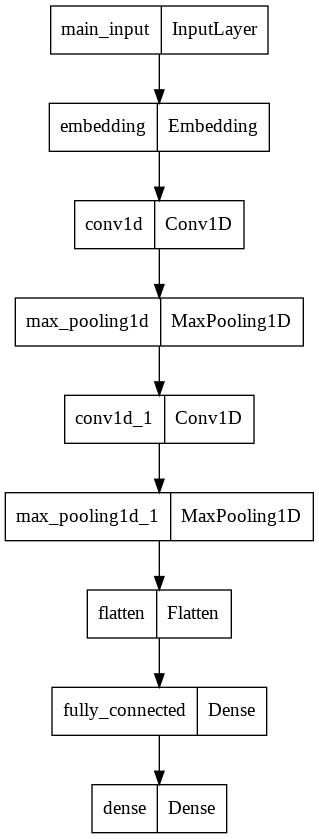

In [ ]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_01, to_file='model_01.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_01')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_01.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [ ]:
c = tf.keras.optimizers.Adam(lr = 0.0001)
model_01.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

h1 = model_01.fit(padded_comments_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(padded_comments_cv, y_cv))

Epoch 1/50
12500/12500 [==============================] - ETA: 0s - loss: 0.6932 - f1_m: 0.4990 - acc: 0.4990
Epoch 1: val_f1_m improved from -inf to 0.50016, saving model to model_01.h5
12500/12500 [==============================] - 863s 69ms/step - loss: 0.6932 - f1_m: 0.4990 - acc: 0.4990 - val_loss: 0.6931 - val_f1_m: 0.5002 - val_acc: 0.5000 - lr: 1.0000e-04
Epoch 2/50
12500/12500 [==============================] - ETA: 0s - loss: 0.6932 - f1_m: 0.5001 - acc: 0.5001
Epoch 2: val_f1_m did not improve from 0.50016
12500/12500 [==============================] - 871s 70ms/step - loss: 0.6932 - f1_m: 0.5001 - acc: 0.5001 - val_loss: 0.6931 - val_f1_m: 0.4998 - val_acc: 0.5000 - lr: 1.0000e-04
Epoch 3/50
12500/12500 [==============================] - ETA: 0s - loss: 0.6932 - f1_m: 0.4993 - acc: 0.4993
Epoch 3: val_f1_m did not improve from 0.50016
12500/12500 [==============================] - 866s 69ms/step - loss: 0.6932 - f1_m: 0.4993 - acc: 0.4993 - val_loss: 0.6931 - val_f1_m: 0.50

In [ ]:
score_1 = model_01.evaluate(padded_comments_test, y_test)
score_1